### 1. Context ###

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

### 2. Attribute Information: ###


1. **age**: in years

2. **sex**: (1 = male; 0 = female)

3. **cp**: chest pain type 
    * Value 0: typical angina
    * Value 1: atypical angina
    * Value 2: non-anginal pain
    * Value 3: asymptomatic 

4. **trestbps**: resting blood pressure (in mm Hg on admission to the hospital)

5. **chol**: serum cholestoral in mg/dl

6. **fbs**: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

7. **restecg**: resting electrocardiographic results
    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 

8. **thalach**: maximum heart rate achieved

9. **exang**: exercise induced angina (1 = yes; 0 = no)

10. **oldpeak**: ST depression induced by exercise relative to rest

11. **slope**: the slope of the peak exercise ST segment
    * Value 0: upsloping
    * Value 1: flat
    * Value 2: downsloping 

12. **ca**: number of major vessels (0-3) colored by flourosopy

13. **thal**: 
    * Value 3 : normal
    * Value 6 : fixed defect
    * Value 7 : reversable defect

14. **target**: 
    * Value 0 : not target
    * Value 1 : target

### 3. Preparation ###

In [1]:
# import necessary packages here
import pandas as pd
import numpy as np

# Common Model Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

# Common Model Helpers
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef, make_scorer

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

import scikitplot
from scikitplot.metrics import plot_cumulative_gain

import shap

# yellowbrick
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.features import RFECV, ParallelCoordinates

# Configure Visualization Defaults
# %matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
plt.style.use('ggplot')
sns.set_style('whitegrid')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\kovus\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


In [2]:
# define a scoring function to print multiple scores
def score_this(pipe):
    skfold = StratifiedKFold(n_splits=5, random_state=43)
    print(f"Score: {pipe.score(X_test, y_test):.6f}"
          f"\nAccuracy: {cross_val_score(pipe, X, y, scoring='accuracy', cv=skfold).mean():.6f}"
          f"\nMatthews: {cross_val_score(pipe, X, y, scoring=matthews, cv=skfold).mean():.6f}"
          f"\nF1: {cross_val_score(pipe, X, y, scoring='f1', cv=skfold).mean():.6f}"
         )
    return

### 4. Gather Data

In [3]:
data = pd.read_csv('heart.csv')

In [4]:
# make a copy of retrieved data
df = data.copy()

# take a look at first 5 rows
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### 5. Check Data

In [5]:
# import pandas_profiling
# pandas_profiling.ProfileReport(df)

In [6]:
# Are there any missing values?
print('There is(are) {} total missing values in dataset'.format(df.isnull().sum().sum()))

# Are there any duplicated samples?
print('There is(are) {} duplicated rows in dataset'.format(df.duplicated().sum()))

There is(are) 0 total missing values in dataset
There is(are) 1 duplicated rows in dataset


In [7]:
# make sure it is a duplicate
df.loc[df.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [8]:
# drop duplicated row
df.drop_duplicates(keep='first', inplace=True)

In [9]:
# preview information on features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


In [10]:
# statistical information on features
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### 6. Explore Data

#### 6.1 Imbalanced Classes

In [11]:
# how many unique values our features have?
pd.DataFrame({'Feature':df.nunique().index, 'Unique values':df.nunique().values})

,Feature,Unique values
0,age,41
1,sex,2
2,cp,4
3,trestbps,49
4,chol,152
5,fbs,2
6,restecg,3
7,thalach,91
8,exang,2
9,oldpeak,40


In [12]:
# separate categorical features(discrete)
cat_cols = df.columns[df.nunique() <= 10]

# separate ordinal columns(continous)
ord_cols = df.columns[df.nunique() > 10]

print(f'Categorical features: {cat_cols.tolist()}\nOrdinal features: {ord_cols.tolist()}')

Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
Ordinal features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


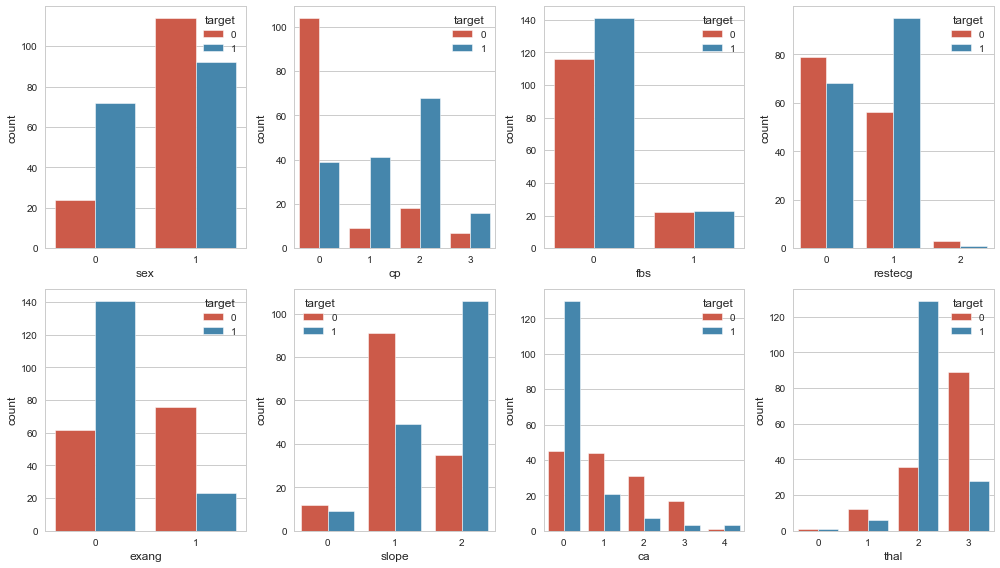

In [13]:
# take a look at categorical feature counts
plt.figure(figsize=(14, 8))

for i in range(len(cat_cols.drop('target'))):
    plt.subplot(2, 4, i+1)
    ax = sns.countplot(x=cat_cols[i], hue='target', data=df)
    plt.tight_layout()

**Inference:** 
- All categorical features are have unequal number of patients representing.

#### 6.2 Categorical variables

In [14]:
df[cat_cols].describe()

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,0.682119,0.963576,0.149007,0.526490,0.327815,1.397351,0.718543,2.314570,0.543046
std,0.466426,1.032044,0.356686,0.526027,0.470196,0.616274,1.006748,0.613026,0.498970
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000
75%,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000
max,1.000000,3.000000,1.000000,2.000000,1.000000,2.000000,4.000000,3.000000,1.000000


In [15]:
# categorical(discrete) variable correlations by target
for col in cat_cols.drop('target'):
    print('Target Correlation by:', col)
    print(df[[col, 'target']].groupby(col).mean()*100)
    print('-'*25, '\n')

Target Correlation by: sex
        target
sex           
0    75.000000
1    44.660194
------------------------- 

Target Correlation by: cp
       target
cp           
0   27.272727
1   82.000000
2   79.069767
3   69.565217
------------------------- 

Target Correlation by: fbs
        target
fbs           
0    54.863813
1    51.111111
------------------------- 

Target Correlation by: restecg
            target
restecg           
0        46.258503
1        62.913907
2        25.000000
------------------------- 

Target Correlation by: exang
          target
exang           
0      69.458128
1      23.232323
------------------------- 

Target Correlation by: slope
          target
slope           
0      42.857143
1      35.000000
2      75.177305
------------------------- 

Target Correlation by: ca
       target
ca           
0   74.285714
1   32.307692
2   18.421053
3   15.000000
4   75.000000
------------------------- 

Target Correlation by: thal
         target
thal           

**Inference from Target Correlation:**

Our sample of 302 patients has following attributes:
- 75% and 44% of female and male patients respectively, have heart disease.
- 69-82% likelihood that you have heart disease if you have **atypical angina, non-anginal pain asymptomatic chest pain**.
- Level of fasting blood sugar isn't indicative of a presence of heart disease.
- 63% likelihood that a patient has heart disease if their resting electrocardiographic result is **"having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)"**.
- 69% likelihood that patient has heart disease if they **get execised induced angina**. 
- 75% likelihood that patient has heart disease if the slope of their **peak exercise ST segment is downsloping**.
- 74% and 80% likelihood that patient has heart disease if their number of **major vessels colored by flourosopy is 0 or4**.
- 78% likelihood that you have heart disease if your thal result is of **fixed defect type**.

#### 6.3 Continuous Variables

In [16]:
df[ord_cols].describe()

,age,trestbps,chol,thalach,oldpeak
count,302.00000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,131.602649,246.500000,149.569536,1.043046
std,9.04797,17.563394,51.753489,22.903527,1.161452
min,29.00000,94.000000,126.000000,71.000000,0.000000
25%,48.00000,120.000000,211.000000,133.250000,0.000000
50%,55.50000,130.000000,240.500000,152.500000,0.800000
75%,61.00000,140.000000,274.750000,166.000000,1.600000
max,77.00000,200.000000,564.000000,202.000000,6.200000


#### Boxplots

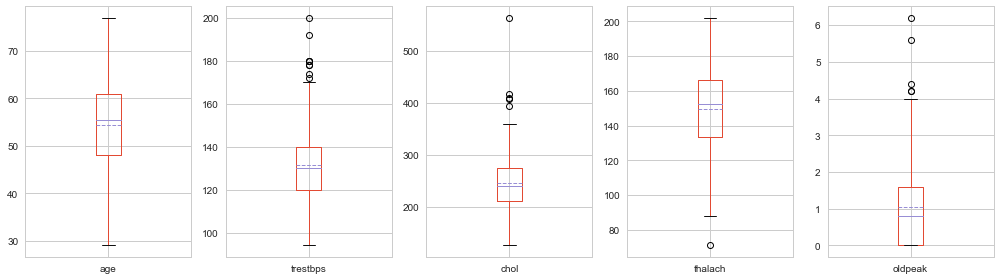

In [17]:
# take a look at continuous variable distributions
plt.figure(figsize=(14, 4))

for i in range(len(ord_cols)):
    plt.subplot(1, 5, i+1)
    ax = df[ord_cols[i]].plot.box(showmeans=True, meanline=True)
    plt.tight_layout()

#### Histograms

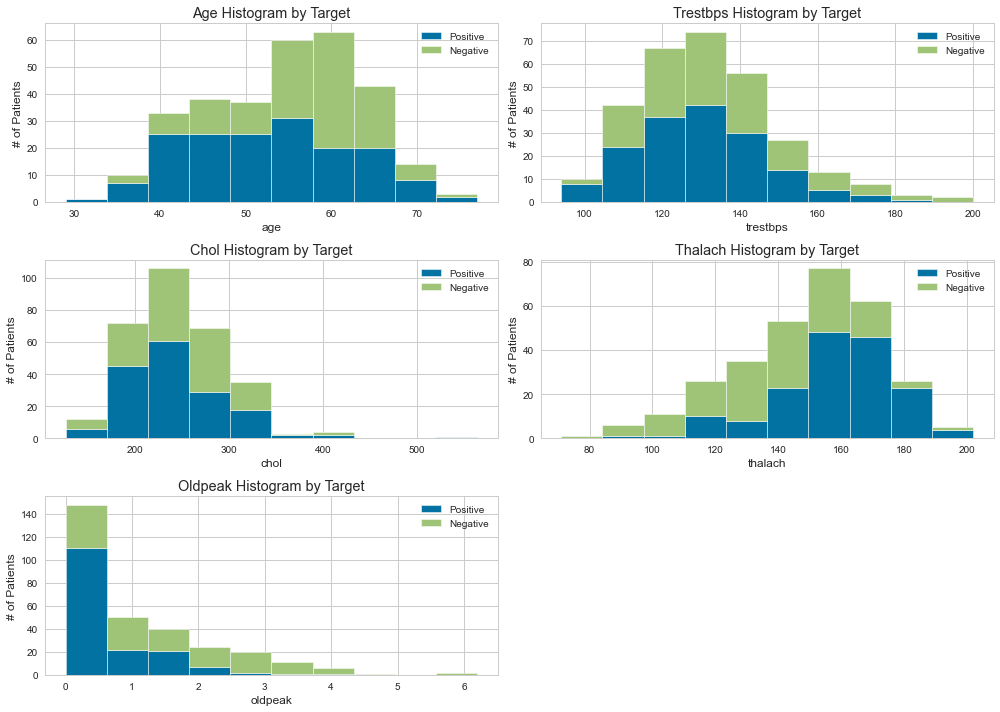

In [18]:
# histograms of continuous variables
plt.figure(figsize=(14, 10))

for i in range(len(ord_cols)):
    plt.subplot(3, 2, i+1)
    plt.hist(x=[df.loc[df['target']==1][ord_cols[i]], df.loc[df['target']==0][ord_cols[i]]],
              stacked=True, color=['b', 'g'],
              label=['Positive', 'Negative']
             )
    plt.title(f'{ord_cols[i].capitalize()} Histogram by Target')
    plt.xlabel(ord_cols[i])
    plt.ylabel('# of Patients')
    plt.legend()
    plt.tight_layout()

#### Parallel Coordinates

Parallel Coordinates visualization makes it easy to see **clusters of data** in individual variables.

In [19]:
# standardize continuous variables for easy comparison when visualizing
scaler = RobustScaler()
dfv = df.drop('target', axis=1)
cols = df.columns
dfv = scaler.fit_transform(df)

# use this dataframe to visualize parallel coordinates below
dfv = pd.DataFrame(dfv, columns=cols)

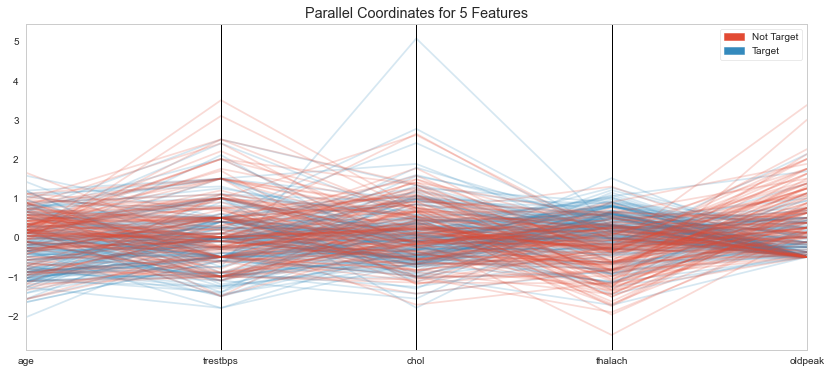

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

# plot parallel coordinates using yellowbrick library
pc = ParallelCoordinates(classes=['Not Target', 'Target'], features=ord_cols, alpha=0.20)
pc.fit(dfv[ord_cols], dfv['target'])
pc.transform(dfv[ord_cols])
ax.set_xticklabels(ax.get_xticklabels())
pc.poof();

**Inference:**

Patients who have heart disease are clustered around:
- Above average **thalach(maximum heart rate achieved)** values
- Below average **oldpeak(ST depression induced by exercise relative to rest)** values

<Figure size 1008x432 with 0 Axes>

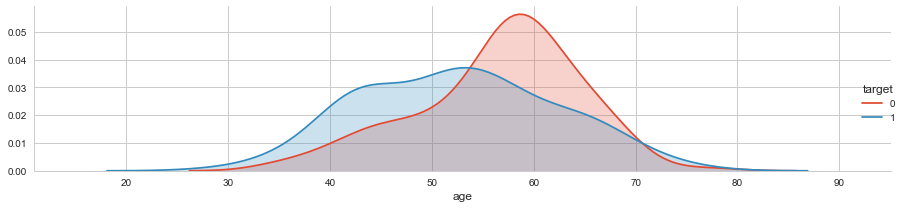

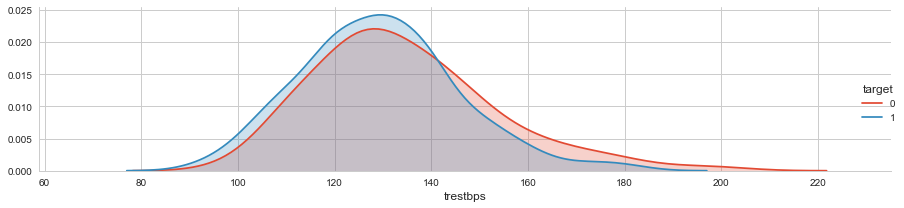

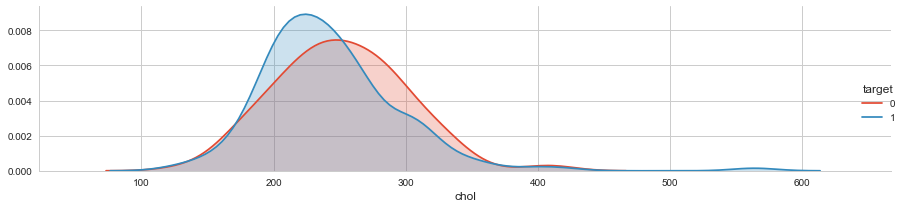

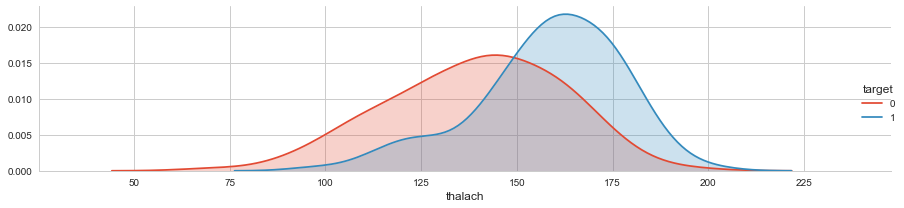

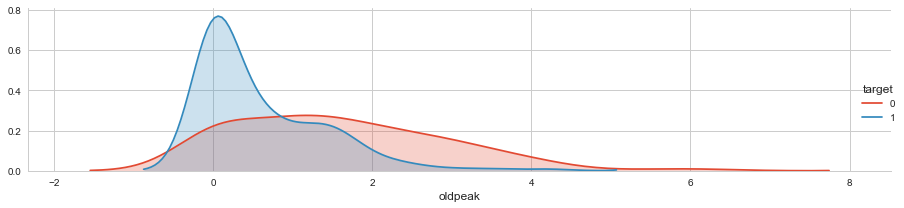

In [21]:
# graph distribution of ordinal(continuous) variables
plt.figure(figsize=(14, 6))
i = 0
for col in ord_cols:
    i += 1
    a = sns.FacetGrid(df, hue='target', aspect=4)
    a.map(sns.kdeplot, col, shade=True)
    a.set(xlim=(df[col].min()-2*df[col].std(), df[col].max()+2*df[col].std()))
    a.add_legend()
    plt.tight_layout();

**Inference:**

- Both target and non-target samples overlap each other a lot in **Age, trestbps(Resting blood pressure) and Cholesterol** plots, meaning these variables are **not indicative** of the presence of heart disease in a patient.

- On the other hand, **oldpeak(ST depression induced by exercise relative to rest) and thalach(maximum heart rate achieved)** are clustered around means with significant difference. We can assume that:
    - Patients with slighly higher maximum heart rate achieved are prone to having heart disease.
    - Patients with oldpeak variable clustered around 0 are prone to having heart disease.

#### Pearson's Correlation Coefficient

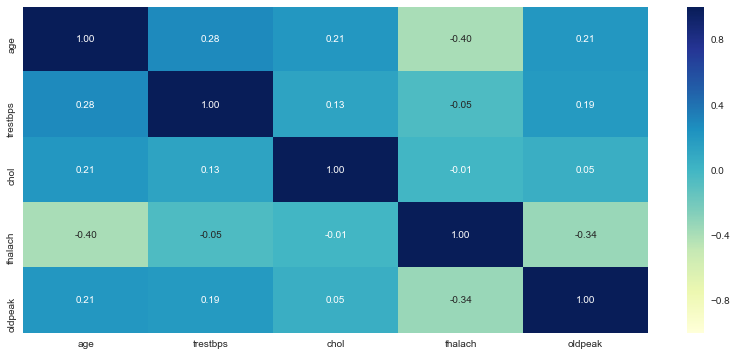

In [22]:
# continuous variable correlation
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df[ord_cols].corr(), fmt='.2f', annot=True, ax=ax, cmap='YlGnBu', vmin=-1, vmax=1);

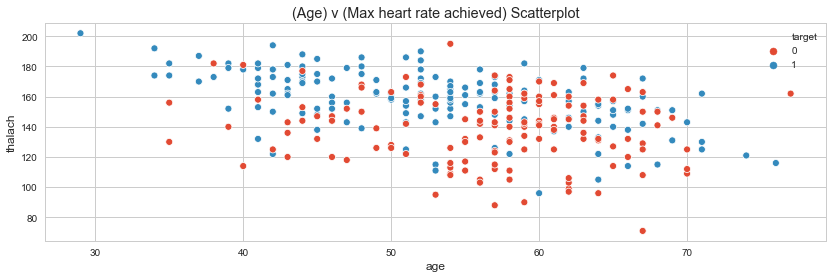

In [23]:
# plot a scatterplot of thalach and oldpeak variables
plt.figure(figsize=(14, 4))

ax = sns.scatterplot(x=df['age'], y=df['thalach'], hue=df['target'])
ax.set_title('(Age) v (Max heart rate achieved) Scatterplot');

**Inference from correlation charts:** 
- There seems to be a _weak negative correlation_ between age and maximum heart rate achieved.
- Looking at both correlation charts of continuous variables there seems to be **no strong correlation** between any two variables in the sample. **Thus, multicollinearity is highly unlikely**.

### 7. Preprocess Data

In [24]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [25]:
# define target vector (y)
y = df['target']

# define features matrix (X)
X = df.drop('target', axis=1)

# look at the sizes of features matrix and target vector
print(f'X: {X.shape}, y: {y.shape}')

X: (302, 13), y: (302,)


In [26]:
# define a column transformer to preprocess both continuous and categorical variables
preprocess = make_column_transformer((OneHotEncoder(), cat_cols.drop('target')), 
                             (RobustScaler(), ord_cols),
                             remainder='passthrough'
                            )
# fit and transform the column transformer using X
preprocess.fit_transform(X)

array([[ 0.        ,  1.        ,  0.        , ..., -0.11764706,
        -0.07633588,  0.9375    ],
       [ 0.        ,  1.        ,  0.        , ...,  0.14901961,
         1.05343511,  1.6875    ],
       [ 1.        ,  0.        ,  0.        , ..., -0.57254902,
         0.59541985,  0.375     ],
       ...,
       [ 0.        ,  1.        ,  1.        , ..., -0.74509804,
        -0.35114504,  1.625     ],
       [ 0.        ,  1.        ,  1.        , ..., -1.71764706,
        -1.14503817,  0.25      ],
       [ 1.        ,  0.        ,  0.        , ..., -0.07058824,
         0.65648855, -0.5       ]])

In [27]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
print(f'X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}')

X_train: (226, 13)
y_train: (226,)
X_test: (76, 13)
y_test: (76,)


## 8. Model Building

### 8.1 Baseline Model

As a baseline we will use null accuracy. Null accuracy can be achieved by always predicting the most frequent class i.e. (“B has the highest frequency, so lets guess B every time”).

In [28]:
# calculate null accuracy for prediction
y.value_counts(normalize=True)

1    0.543046
0    0.456954
Name: target, dtype: float64

54% of patients in our dataset are targets, meaning they have heart disease. I will try and build a model that outperforms baseline model.

### 8.2 Various Classifiers

We will define Matthews correlation coefficient which is a better evaluation metrics for classification models used on imbalanced target variables.

In [29]:
# define matthews score to use in cross validation scoring
matthews = make_scorer(matthews_corrcoef)

We will take a look at different classifiers below by fitting, training and evaluating accuracy and Matthews correlation coefficient for every model:

In [30]:
for model in [LogisticRegression,
              DecisionTreeClassifier,
              KNeighborsClassifier,
              GaussianNB,
              SVC,
              RandomForestClassifier,
              XGBClassifier
             ]:
    classifier = model()
    skfold = StratifiedKFold(n_splits=5)
    score = cross_val_score(classifier, X, y, scoring='accuracy', cv=skfold)
    print(f'{model.__name__:25}classifier '
          f'Accuracy: {score.mean():.3f} STD: {score.std():.3f}')

LogisticRegression       classifier Accuracy: 0.834 STD: 0.044
DecisionTreeClassifier   classifier Accuracy: 0.748 STD: 0.065
KNeighborsClassifier     classifier Accuracy: 0.642 STD: 0.052
GaussianNB               classifier Accuracy: 0.814 STD: 0.051
SVC                      classifier Accuracy: 0.646 STD: 0.071
RandomForestClassifier   classifier Accuracy: 0.818 STD: 0.048
XGBClassifier            classifier Accuracy: 0.804 STD: 0.030


In [31]:
for model in [LogisticRegression,
              DecisionTreeClassifier,
              KNeighborsClassifier,
              GaussianNB,
              SVC,
              RandomForestClassifier,
              XGBClassifier
             ]:
    classifier = model()
    skfold = StratifiedKFold(n_splits=5)
    score = cross_val_score(classifier, X, y, scoring=matthews, cv=skfold)
    print(f'{model.__name__:25}classifier '
          f'Matthews score: {score.mean():.3f} STD: {score.std():.3f}')

LogisticRegression       classifier Matthews score: 0.670 STD: 0.086
DecisionTreeClassifier   classifier Matthews score: 0.525 STD: 0.084
KNeighborsClassifier     classifier Matthews score: 0.274 STD: 0.106
GaussianNB               classifier Matthews score: 0.629 STD: 0.102
SVC                      classifier Matthews score: 0.280 STD: 0.147
RandomForestClassifier   classifier Matthews score: 0.663 STD: 0.078
XGBClassifier            classifier Matthews score: 0.614 STD: 0.055


Without any preprocessing the dataset accuracy scores top 3 accuracy and Matthews correlation coefficient scores belong to:
1. Logistic Regression
2. Gaussian Naive Bayes Classifier
3. Random Forest Classifier **

In [32]:
for model in [LogisticRegression,
              DecisionTreeClassifier,
              KNeighborsClassifier,
              GaussianNB,
              SVC,
              RandomForestClassifier,
              XGBClassifier
             ]:
    classifier = model()
    pipe = make_pipeline(preprocess, classifier)    
    skfold = StratifiedKFold(n_splits=5, random_state=43)
    score = cross_val_score(pipe, X, y, scoring='accuracy', cv=skfold)
    print(f'{model.__name__:25}pipeline '
          f'Accuracy: {score.mean():.3f} STD: {score.std():.3f}')

LogisticRegression       pipeline Accuracy: 0.844 STD: 0.041
DecisionTreeClassifier   pipeline Accuracy: 0.728 STD: 0.084
KNeighborsClassifier     pipeline Accuracy: 0.847 STD: 0.052
GaussianNB               pipeline Accuracy: 0.781 STD: 0.053
SVC                      pipeline Accuracy: 0.827 STD: 0.051
RandomForestClassifier   pipeline Accuracy: 0.848 STD: 0.027
XGBClassifier            pipeline Accuracy: 0.814 STD: 0.040


In [33]:
for model in [LogisticRegression,
              DecisionTreeClassifier,
              KNeighborsClassifier,
              GaussianNB,
              SVC,
              RandomForestClassifier,
              XGBClassifier
             ]:
    classifier = model()
    pipe = make_pipeline(preprocess, classifier)    
    skfold = StratifiedKFold(n_splits=5,random_state=43)
    score = cross_val_score(pipe, X, y, scoring=matthews, cv=skfold)
    print(f'{model.__name__:25}pipeline '
          f'Matthews score: {score.mean():.3f} STD: {score.std():.3f}')

LogisticRegression       pipeline Matthews score: 0.689 STD: 0.082
DecisionTreeClassifier   pipeline Matthews score: 0.439 STD: 0.169
KNeighborsClassifier     pipeline Matthews score: 0.695 STD: 0.105
GaussianNB               pipeline Matthews score: 0.577 STD: 0.094
SVC                      pipeline Matthews score: 0.655 STD: 0.101
RandomForestClassifier   pipeline Matthews score: 0.677 STD: 0.072
XGBClassifier            pipeline Matthews score: 0.636 STD: 0.079


Pipelining machine learning models while utilizing preprocessing methods like standardizing continuous variables and one hot encoding categorical variables improves the scores. Here top 3 classifiers are:
1. K-Neighbors Classifier
2. Logistic Regression
3. Support Vector Classifier

We will take a look at them respectively.

### 8.3 Logistic Regression

In [34]:
# define, fit and evaluate a simple Logistic Regression classifier
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.8947368421052632

In [35]:
# take a look into Logistic Regression feature importances
print('Feature Importances:')
for col, val in sorted(zip(X.columns, logreg.coef_[0]),
                       key=lambda x: x[1],
                       reverse=True
                      ):
    print(f'{col:10}{val:10.3f}')

Feature Importances:
cp             0.729
slope          0.635
restecg        0.475
thalach        0.023
age            0.007
chol          -0.001
trestbps      -0.018
fbs           -0.233
oldpeak       -0.373
thal          -0.606
ca            -0.689
exang         -0.810
sex           -0.819


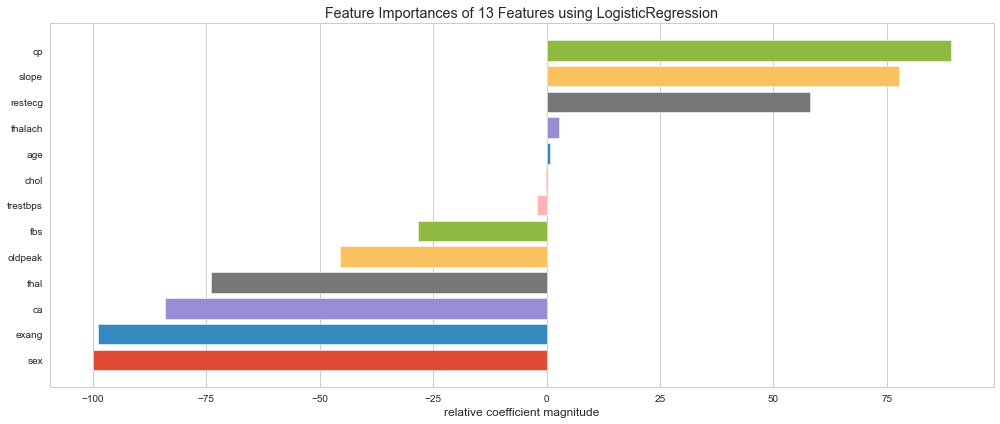

In [36]:
# visualize feature importances using yellowbrick library
fig, ax = plt.subplots(figsize=(14, 6))
logr_fi = FeatureImportances(logreg)
logr_fi.fit(X, y)
logr_fi.poof();

In [37]:
# define and fit a Logistic Regression pipeline
# use predefined column transformer to preprocess predictive features
log_pipe = make_pipeline(preprocess, logreg)
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], dtype='object')),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], dtype='object'))])),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [65]:
print('Logistic Regression classifier scores')
score_this(log_pipe)

Logistic Regression classifier scores
Score: 0.894737
Accuracy: 0.844098
Matthews: 0.689059
F1: 0.858925


#### Classification Report

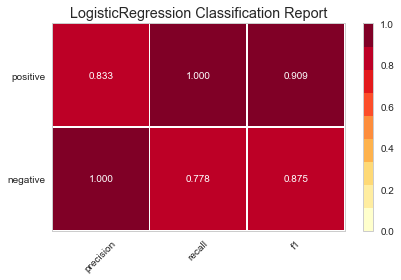

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))
logr_cr = ClassificationReport(log_pipe, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
logr_cr.score(X_test, y_test)
logr_cr.poof();

#### Confusion Matrix

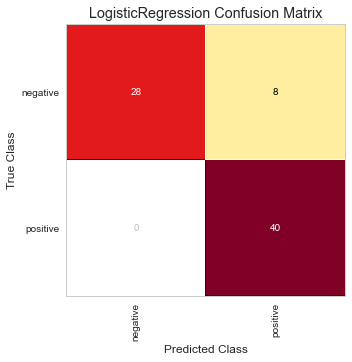

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
lp_cm = ConfusionMatrix(log_pipe, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
lp_cm.score(X_test, y_test)
lp_cm.poof();

#### ROC Curve

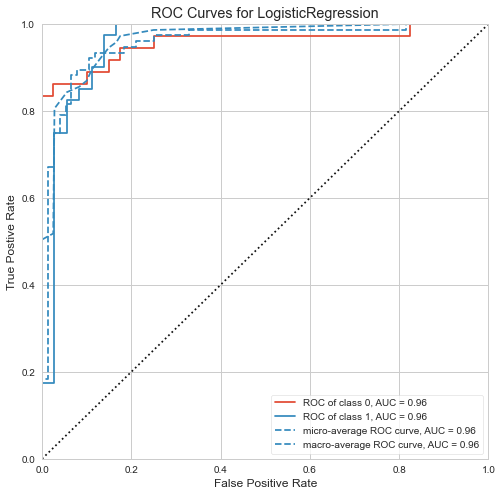

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
lp_roc = ROCAUC(log_pipe)
lp_roc.score(X_test, y_test)
lp_roc.poof();

#### Learning Curve

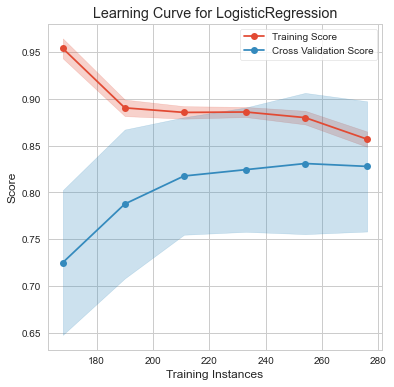

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
logr_lc = LearningCurve(logreg, cv=cv, train_sizes=sizes, n_jobs=-1, ax=ax)
logr_lc.fit(X, y)
logr_lc.poof();

**Inference:**

Learning curve shows that Logistic Regression Classifier is **improving with more training**. Difference between Training and Cross Validation Scores are minimizing with more data.

### 8.4 K-Neighbours Classifier

In [78]:
# define, fit and evaluate a simple K-Neighbours classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.6842105263157895

In [79]:
# define and fit a K-Neighbours Classifier pipeline
# use predefined column transformer to preprocess predictive features
knn_pipe = make_pipeline(preprocess, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], dtype='object')),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], dtype='object'))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [80]:
print('K-Neighbors classifier scores')
score_this(knn_pipe)

K-Neighbors classifier scores
Score: 0.802632
Accuracy: 0.847432
Matthews: 0.694839
F1: 0.862141


#### Classification Report

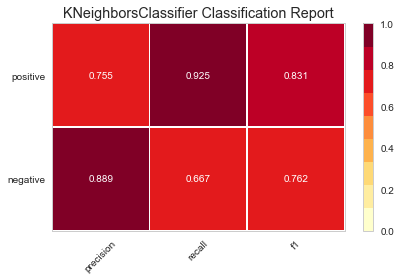

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))
knn_cr = ClassificationReport(knn_pipe, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
knn_cr.score(X_test, y_test)
knn_cr.poof();

#### Confusion Matrix

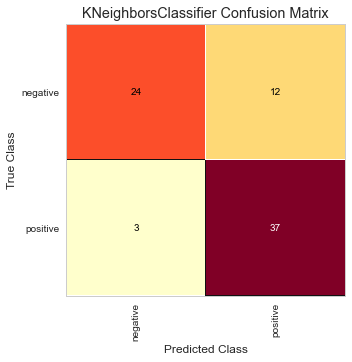

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))
knn_cm = ConfusionMatrix(knn_pipe, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
knn_cm.score(X_test, y_test)
knn_cm.poof();

#### ROC Curve

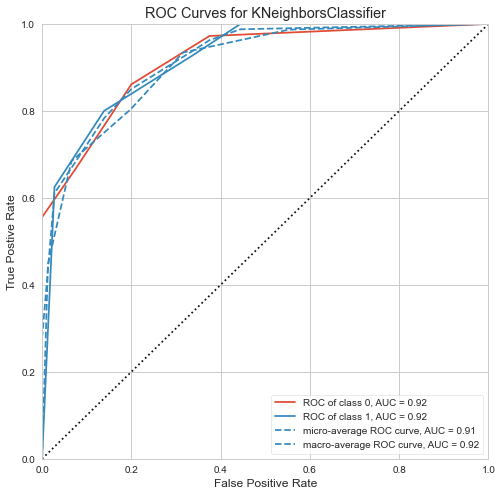

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
knn_roc = ROCAUC(knn_pipe)
knn_roc.score(X_test, y_test)
knn_roc.poof();

#### Learning Curve

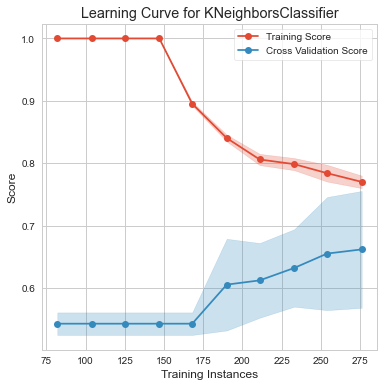

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
logr_lc = LearningCurve(knn, cv=cv, train_sizes=sizes, scoring='accuracy', n_jobs=-1, ax=ax)
logr_lc.fit(X, y)
logr_lc.poof();

**Inference:**

Both training and validation scores regress with more training showing our classifier has **underfitting** problem, in other words **high bias**. My opinion is that K-Neighbours classifier is most sensitive to euclidean distance between each data point. Since we feed raw data without preprocessing, in this case standardization, our classifier performs very poorly.

### 8.5 Random Forest Classifier

In [50]:
# define, fit and evaluate a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=43)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.881578947368421

In [51]:
# Feature Importances
print('Feature Importances:')
for col, val in sorted(zip(X_train.columns, rf.feature_importances_),
                       key = lambda x: x[1],
                       reverse=True
                      ):
    print(f'{col:10} {val:10.3f}')

Feature Importances:
thalach         0.124
oldpeak         0.117
cp              0.115
ca              0.108
trestbps        0.090
age             0.086
chol            0.086
thal            0.081
slope           0.074
exang           0.065
sex             0.025
restecg         0.019
fbs             0.010


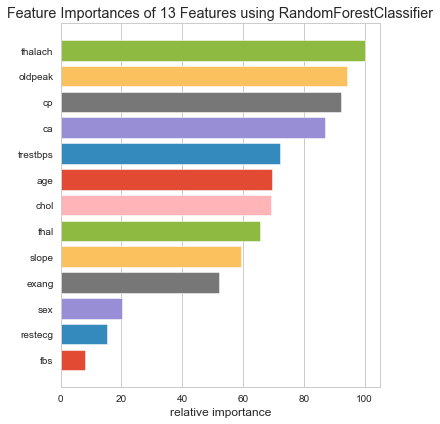

In [52]:
fig, ax = plt.subplots(figsize=(6, 6))
rf_fi = FeatureImportances(rf)
rf_fi.fit(X, y)
rf_fi.poof();

In [53]:
# define and fit a Random Forest Classifier pipeline
# use predefined column transformer to preprocess predictive features
rf_pipe = make_pipeline(preprocess, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], dtype='object')),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=43))])

In [54]:
print('Random Forest classifier scores')
score_this(rf_pipe)

Score: 0.868421
Accuracy: 0.820874
Matthews: 0.642352
F1: 0.836511


#### Classification Report

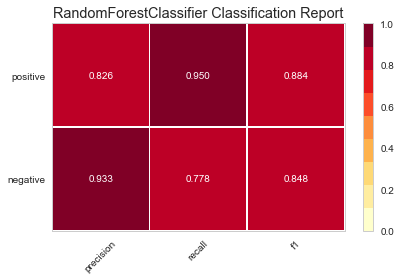

In [55]:
fig, ax = plt.subplots(figsize=(6, 4))
rf_cr = ClassificationReport(rf_pipe, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
rf_cr.score(X_test, y_test)
rf_cr.poof();

#### Confusion Matrix

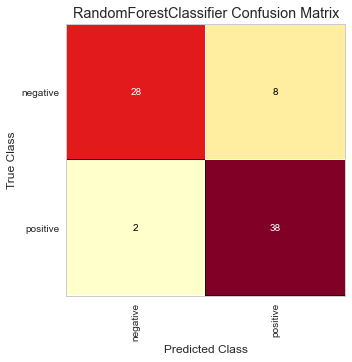

In [56]:
fig, ax = plt.subplots(figsize=(5, 5))
rf_cm = ConfusionMatrix(rf_pipe, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
rf_cm.score(X_test, y_test)
rf_cm.poof();

#### ROC Curve

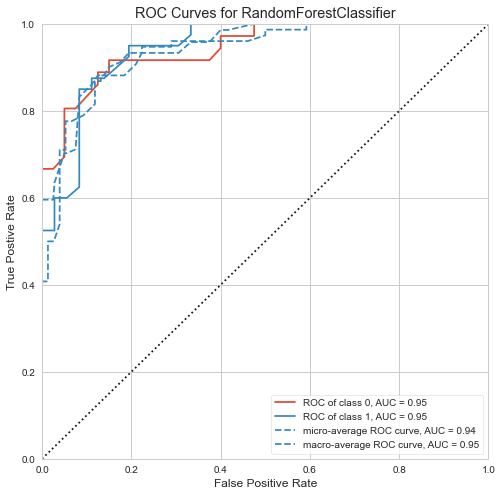

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))
rf_roc = ROCAUC(rf_pipe)
rf_roc.score(X_test, y_test)
rf_roc.poof();

#### Learning Curve

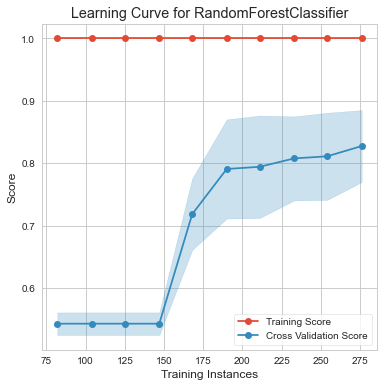

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
rf_lc = LearningCurve(rf, cv=cv, train_sizes=sizes, scoring='accuracy', n_jobs=-1, ax=ax)
rf_lc.fit(X, y)
rf_lc.poof();

**Inference:**

Random Forest Classifier's learning curve shows **significant improvement with more data**. Starting with 50% accuracy the classifier improves with more training.

### 8.6 Stacking classifiers

We will try out stacking and see if it improves the score.

In [59]:
from mlxtend.classifier import StackingClassifier

classifiers = [x() for x in [LogisticRegression,
                             DecisionTreeClassifier,
                             KNeighborsClassifier,
                             GaussianNB,
                             SVC,
                             RandomForestClassifier,
                             XGBClassifier
                            ]
              ]
skfold = StratifiedKFold(n_splits=10, random_state=43)
stc = StackingClassifier(classifiers=classifiers, meta_classifier=LogisticRegression())
score = cross_val_score(stc, X, y, scoring='accuracy', cv=skfold)
print(f'stc.__name__:'
      f'AUC: {score.mean():.3f} STD: {score.std():.3f}')

stc.__name__:AUC: 0.811 STD: 0.058


In [60]:
from mlxtend.classifier import StackingClassifier

classifiers = [x() for x in [LogisticRegression,
                             DecisionTreeClassifier,
                             KNeighborsClassifier,
                             GaussianNB,
                             SVC,
                             RandomForestClassifier,
                             XGBClassifier
                            ]
              ]
skfold = StratifiedKFold(n_splits=10, random_state=43)
stc = StackingClassifier(classifiers=classifiers, meta_classifier=LogisticRegression())
score = cross_val_score(stc, X, y, scoring=matthews, cv=skfold)
print(f'stc.__name__:'
      f'AUC: {score.mean():.3f} STD: {score.std():.3f}')

stc.__name__:AUC: 0.622 STD: 0.145


Stacking the classifiers doesn't significantly improve neither accuracy score nor Matthews correlation coefficient. Proceeding with stacking the classifiers might not be computationally feasible.

### 8.7 Optimize Model

Below we will tune hyperparameters of our Random Forest classifier and attempt to increase model's accuracy.

In [61]:
# cv = model_selection.GridSearchCV(rf, params, n_jobs=-1).fit(X_train, y_train)
# print(cv.best_params_)

NameError: name 'model_selection' is not defined

In [ ]:
# rf_test = ensemble.RandomForestClassifier(random_state=43)
# # params = {'max_features': [0.4, 'auto'],
# #           'n_estimators': [15, 100],
# #           'min_samples_leaf': [1, 0.1],
# #          }
# cv = model_selection.GridSearchCV(rf, params, n_jobs=-1).fit(X_train, y_train)
# print(cv.best_params_)

In [ ]:
# rf_best = ensemble.RandomForestClassifier(**{'max_features': 'auto',
#                                              'n_estimators': 200,
#                                              'min_samples_leaf': 0.1,
#                                              'random_state': 43
#                                             })
# rf_best.fit(X_train, y_train)

In [82]:
# score_this()

TypeError: score_this() missing 1 required positional argument: 'pipe'

**Inference:**

Learning curve shows us that our Random Forest Classifier might be suffering from high bias(underfitting) since both Training and Cross Validation Scores are lower than Logistic Classifier's scores. Depending on the importance of ~5% accuracy, **more complex(polynomial features) models or using more features** might fix our underfitting problem.

### 9. Explainability

### Shapley

In [ ]:
shap.initjs()

s = shap.TreeExplainer(rf_best)
shap_vals = s.shap_values(X_test)
shap.force_plot(s.expected_value[0],
                shap_vals[0][3, :],
                feature_names=X.columns
               )


In [ ]:
shap.dependence_plot('age',
                     shap_vals[0],
                     X_test,
                     feature_names=X_test.columns,
                     alpha=0.5
                    )

In [ ]:
shap.dependence_plot('oldpeak',
                     shap_vals[0],
                     X_test,
                     feature_names=X_test.columns,
                     alpha=0.5
                    )

In [ ]:
shap.dependence_plot('chol',
                     shap_vals[0],
                     X_test,
                     feature_names=X_test.columns,
                     alpha=0.5
                    )

In [ ]:
shap.dependence_plot('trestbps',
                     shap_vals[0],
                     X_test,
                     feature_names=X_test.columns,
                     alpha=0.5
                    )

In [ ]:
shap.summary_plot(shap_vals[0], X_test)

### Feature Selection

### RFE

In [ ]:
fig, ax = plt.subplots(figsize=(8 ,8))
rfe = RFECV(logreg, cv=5)
rfe.fit(X, y)
rfe.poof();

In [ ]:
rfe.rfe_estimator_.ranking_

In [ ]:
rfe.rfe_estimator_.n_features_

In [ ]:
X.columns[rfe.rfe_estimator_.support_]

**Inference:**

Recursive Feature Elimination showed that **10 out of 13 features we have in our dataset are essential in predicting the outcome.** Thus, we cannot drop them.